__Integrantes:__
- _Esteban Andrés Arroyave Lopez_
- _Manuel Enrique Luna Alegría_

In [352]:
# 1) Importaciones y configuración
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 120

##  TAREA 2: ACP normado de datos de café

El presente análisis utiliza una base de datos de catación de café, en la que se recogen evaluaciones sensoriales y de calidad de un conjunto de 1337 muestras. Cada registro corresponde a una cata de café que da como resultado las puntuaciones numéricas en una escala de 0 a 10 o 0 a 100, con características cualitativas relacionadas con la especie y el país de origen.

Las variables numéricas incluyen atributos sensoriales tales como Fragrance.Aroma, Flavor, Aftertaste, Salt.Acid, Mouthfeel, Balance, Bitter.Sweet, Uniform.Cup, Clean.Cup y Cupper.Points, además de un indicador global de calidad (quality_score). Estas métricas permiten evaluar la experiencia de consumo del café desde diferentes dimensiones, combinando percepción olfativa, gustativa y criterios de uniformidad y limpieza de la taza.

Las variables cualitativas suplementarias son _Species_ (especie de café: por ejemplo, Arábica o Robusta) y _Country.of.Origin_ (país de origen del grano). Estas no se emplean en la construcción de los componentes, pero son útiles para interpretar patrones de agrupación en función de características geográficas o botánicas.

El objetivo principal del presente estudio es aplicar un Análisis de Componentes Principales (ACP) a los datos de cata de café para:

1. Reducir la dimensionalidad de las variables numéricas, sintetizando la información en unos pocos ejes.

2. Explorar la estructura de relaciones entre atributos sensoriales y el puntaje global de calidad.

3. Identificar patrones y diferencias entre individuos (muestras de café) y posibles valores atípicos.

4. Analizar el rol de las variables cualitativas como factores explicativos suplementarios.

5. Construir un índice sintético de calidad basado en el primer componente principal, escalado de 0 a 100, que facilite la interpretación y comparación entre muestras.

6. Generar agrupamientos usando las técnicas de la clase, conformando grupos a partir de las nubes de los individuos.

En conjunto, este análisis busca caracterizar de manera multivariada la calidad del café y ofrecer herramientas de síntesis que permitan comprender mejor cómo se interrelacionan los atributos sensoriales, los puntajes de catación y el origen de las muestras.


### Descripción de variables del dataset

<div align="center">
<p style="font-size:10px">

| Variable           | Tipo        | Descripción                                                                 |
|--------------------|-------------|-----------------------------------------------------------------------------|
| **Fragrance...Aroma** | Numérica (0–10) | Intensidad y calidad del aroma del café percibido en seco y húmedo. |
| **Flavor**         | Numérica (0–10) | Complejidad y riqueza del sabor general de la taza.                   |
| **Aftertaste**     | Numérica (0–10) | Persistencia y calidad del sabor residual tras la degustación.        |
| **Salt...Acid**    | Numérica (0–10) | Balance y agradable percepción de acidez característica del café.     |
| **Mouthfeel**      | Numérica (0–10) | Sensación táctil en boca: cuerpo, textura y peso del café.            |
| **Balance**        | Numérica (0–10) | Armonía global de los atributos sensoriales evaluados.                |
| **Bitter...Sweet** | Numérica (0–10) | Relación percibida entre amargor y dulzor en la taza.                 |
| **Uniform.Cup**    | Numérica (0–10) | Consistencia de las tazas catadas: ausencia de variaciones notables.  |
| **Clean.Cup**      | Numérica (0–10) | Ausencia de defectos o sabores indeseados en la muestra.              |
| **Cupper.Points**  | Numérica (0–10) | Puntuación otorgada por el catador como síntesis profesional.         |
| **quality_score**  | Numérica (≈0–100) | Calificación global de calidad del café, agregada a partir de los atributos. |
| **Species**        | Cualitativa | Especie botánica del grano (ej. *Arabica*, *Robusta*).                  |
| **Country.of.Origin** | Cualitativa | País de procedencia del café.                                           |


</div>
   </p>

### ANÁLISIS EXPLORATORIO DE LOS DATOS

In [450]:
# 2) Cargar datos (autodetección de separador) y limpieza mínima
path = r"C:\Users\Esteban\Desktop\ESTEBAN\1UAO\SEMESTRE II\ESTADISTICA MULTIVARIADA\TAREA 2\coffeData.csv"
#path = "coffeData.csv"  # <-- cambia esta ruta si tu archivo está en otro sitio
df = pd.read_csv(path, sep=";")

# Eliminar columna índice si existe
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"]).copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Species            1337 non-null   object 
 1   Country.of.Origin  1337 non-null   object 
 2   Fragrance...Aroma  1337 non-null   float64
 3   Flavor             1337 non-null   float64
 4   Aftertaste         1337 non-null   float64
 5   Salt...Acid        1337 non-null   float64
 6   Mouthfeel          1337 non-null   float64
 7   Balance            1337 non-null   float64
 8   Bitter...Sweet     1337 non-null   float64
 9   Uniform.Cup        1337 non-null   float64
 10  Clean.Cup          1337 non-null   float64
 11  Cupper.Points      1337 non-null   float64
 12  quality_score      1337 non-null   float64
dtypes: float64(11), object(2)
memory usage: 135.9+ KB


In [451]:
# 3) Identificar variables numéricas y cualitativas (suplementarias) + imputar NA numéricos por la media
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
qual_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

df_numeric = df[numeric_cols].copy()

# impute_values = df_numeric.mean(numeric_only=True)

df_numeric_imputed = df_numeric

print("Numéricas:", numeric_cols)
print("Cualitativas (supl.):", qual_cols)


Numéricas: ['Fragrance...Aroma', 'Flavor', 'Aftertaste', 'Salt...Acid', 'Mouthfeel', 'Balance', 'Bitter...Sweet', 'Uniform.Cup', 'Clean.Cup', 'Cupper.Points', 'quality_score']
Cualitativas (supl.): ['Species', 'Country.of.Origin']


En este paso se identificaron como variables numéricas: Fragrance...Aroma, Flavor, Aftertaste, Salt...Acid, Mouthfeel, Balance, Bitter...Sweet, Uniform.Cup, Clean.Cup, Cupper.Points y quality_score, las cuales serán la base del ACP. Como variables cualitativas suplementarias se reconocieron Species y Country.of.Origin. Adicionalmente, no se presentan valores faltantes en las variables numéricas a ser imputados concluyendo que se cuentan con los datos completos para realizar la estandarización y el análisis posterior.

### Estadísticos descriptivos de las variables sensoriales

<div align="center">
<p style="font-size:10px">


| Variable           | mean  | std  | min  | 25%  | 50%  | 75%  | max  |
|--------------------|-------|------|------|------|------|------|------|
| **Fragrance...Aroma** | 7.57  | 0.32 | 5.08 | 7.42 | 7.58 | 7.75 | 8.75 |
| **Flavor**         | 7.53  | 0.34 | 6.08 | 7.33 | 7.58 | 7.75 | 8.83 |
| **Aftertaste**     | 7.41  | 0.35 | 6.17 | 7.25 | 7.42 | 7.58 | 8.67 |
| **Salt...Acid**    | 7.54  | 0.32 | 5.25 | 7.33 | 7.58 | 7.75 | 8.75 |
| **Mouthfeel**      | 7.52  | 0.36 | 5.08 | 7.33 | 7.50 | 7.75 | 8.75 |
| **Balance**        | 9.87  | 0.52 | 5.25 | 10.00 | 10.00 | 10.00 | 10.00 |
| **Bitter...Sweet** | 7.53  | 0.29 | 5.25 | 7.33 | 7.50 | 7.67 | 8.58 |
| **Uniform.Cup**    | 9.84  | 0.48 | 6.00 | 10.00 | 10.00 | 10.00 | 10.00 |
| **Clean.Cup**      | 9.85  | 0.68 | 0.00 | 10.00 | 10.00 | 10.00 | 10.00 |
| **Cupper.Points**  | 7.51  | 0.43 | 5.17 | 7.25 | 7.50 | 7.75 | 10.00 |
| **quality_score**  | 82.17 | 2.62 | 63.08 | 81.17 | 82.50 | 83.67 | 90.58 |

</p>
</div>

En general, los atributos sensoriales del café (aroma, sabor, regusto, acidez, sensación en boca y dulzor-amargor) presentan medias cercanas a 7.5, con desviaciones estándar bajas (≈0.3–0.4), lo que indica evaluaciones consistentes y homogéneas entre muestras.

Las variables Uniform Cup, Clean Cup y Balance destacan con valores medios cercanos a 10, mostrando una alta uniformidad y limpieza en la mayoría de las tazas evaluadas, con poca variabilidad.

En contraste, atributos como Aftertaste y Bitter–Sweet muestran mayor dispersión en sus valores mínimos y máximos, evidenciando cierta diversidad en la percepción de regusto y balance dulce-amargo.

Finalmente, la variable quality_score de color verde oscuro, es una variable con un rango que va desde 0 a 100 y exhibe un promedio alto (≈82), pero con una variabilidad mayor (desviación estándar ≈2.6 y rango entre 63 y 90), lo que refleja que, aunque la mayoría de los cafés son de buena calidad, existen diferencias notables en el puntaje global, probablemente influenciadas por variaciones en atributos clave como regusto y dulzor-amargor.

#### Matriz de correlacion de variables

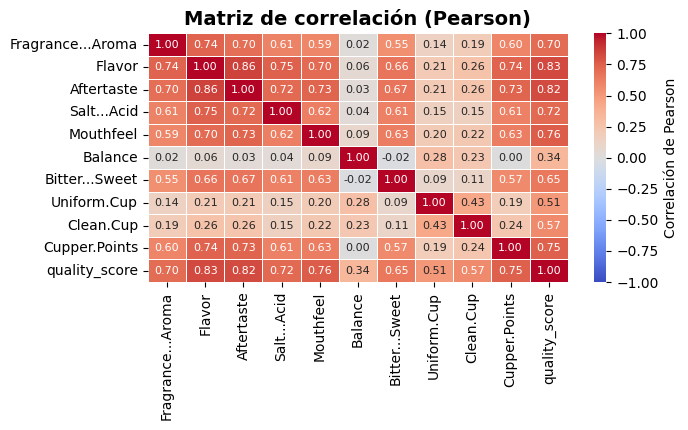

In [452]:
corr = df_numeric_imputed.corr() 
plt.figure(figsize=(max(7, len(corr.columns)*0.6), max(4, len(corr.columns)*0.4)))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", annot_kws={"size": 8},
            linewidths=0.4, cbar_kws={"label": "Correlación de Pearson"})
plt.title("Matriz de correlación (Pearson)", fontsize=14, fontweight="bold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


La matriz de correlación evidencia que el quality_score se asocia fuertemente con Flavor (0.83), Aftertaste (0.82), Mouthfeel (0.76) y Cupper Points (0.75), confirmando que los atributos vinculados al gusto son determinantes en la evaluación global del café. Asimismo, se observa una estrecha relación entre Flavor y Aftertaste (0.86), lo que refleja coherencia en la experiencia sensorial. En contraste, variables como Balance presentan correlaciones débiles, indicando un peso marginal en la calificación final.

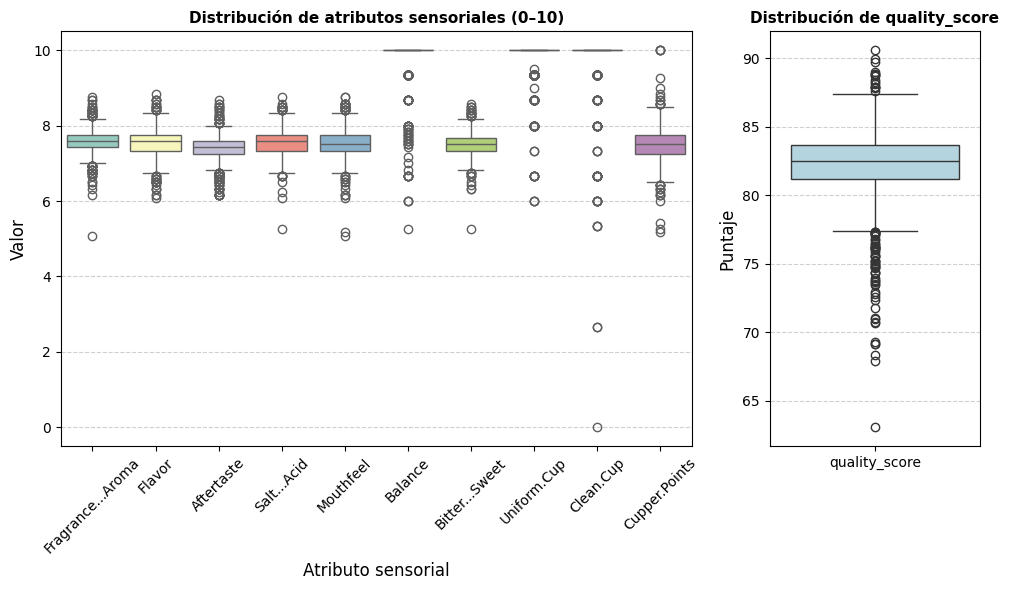

In [453]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(10,6), gridspec_kw={'width_ratios': [3, 1]})

# --- Gráfico 1: Boxplots de atributos sensoriales (excepto quality_score) ---
sns.boxplot(
    data=df_numeric_imputed.drop(columns=["quality_score"]),
    palette="Set3", ax=axes[0]
)
axes[0].set_title("Distribución de atributos sensoriales (0–10)", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Valor", fontsize=12)
axes[0].set_xlabel("Atributo sensorial", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# --- Gráfico 2: Boxplot para quality_score ---
sns.boxplot(
    data=df_numeric_imputed[["quality_score"]],
    color="lightblue", ax=axes[1],
    orient = "v"
)
axes[1].set_title("Distribución de quality_score", fontsize=11, fontweight="bold")
axes[1].set_ylabel("Puntaje", fontsize=12)
axes[1].set_xlabel("")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

# Ajustar layout
plt.tight_layout()
plt.show()


En el primer panel se muestran los atributos sensoriales del café evaluados en escala de 0 a 10. La mayoría de ellos se concentran alrededor de valores altos, entre 7 y 8 puntos, con cajas estrechas que reflejan poca variabilidad. Esto indica que la evaluación de características como Fragrance, Flavor, Aftertaste, Acidity, Mouthfeel y Cupper Points es consistente entre muestras. Algunos atributos como Balance, Uniform Cup y Clean Cup presentan medianas en el rango superior (cercanas a 10), lo que evidencia que casi todas las tazas cumplen con estándares de uniformidad, limpieza y balance. Sin embargo, también se observan outliers en varios atributos, lo que señala diferencias puntuales en ciertas muestras, aunque no representan la tendencia general.

En el segundo panel, el boxplot de quality_score muestra una mediana en torno a 82 puntos, con una distribución relativamente compacta entre 80 y 85. No obstante, hay presencia de valores atípicos hacia la parte baja (≈65–75), que corresponden a cafés de calidad inferior. También se observan algunos valores altos, cercanos a 90, que representan cafés de calidad excepcional.

### REDUCCIÓN DE LA DIMENSIONALIDAD - APLICACIÓN DEL ANÁLISIS DE COMPONENTES PRINCIPALES

### Inercia analizada en ejes

In [454]:
X = df_numeric_imputed  # si no quieres incluir la target

# --- Estandarización (importante para PCA sobre corr) ---
X_scaled = StandardScaler().fit_transform(X)

# --- PCA ---
pca = PCA()
pca.fit_transform(X_scaled)
scores = pca.transform(X_scaled)
# Eigenvalues = varianza explicada por cada componente * número de variables
eigenvalues = pca.explained_variance_

# Varianza explicada individual
explained_ratio = pca.explained_variance_ratio_

# Varianza acumulada
cum_explained = np.cumsum(explained_ratio)


In [455]:
explained_ratio

array([5.49797309e-01, 1.49468874e-01, 7.19480044e-02, 5.23723296e-02,
       4.24330490e-02, 3.61056108e-02, 3.38474333e-02, 3.07765090e-02,
       2.12250096e-02, 1.20231740e-02, 2.69709432e-06])

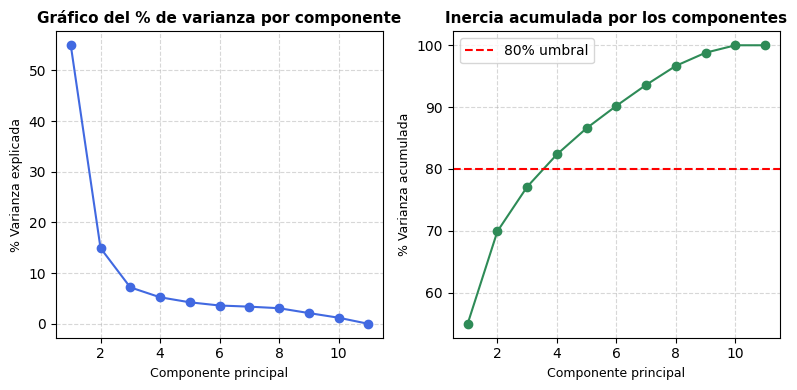

In [456]:
import matplotlib.pyplot as plt
import numpy as np

# Ejes y varianza explicada
x = np.arange(1, len(eigenvalues) + 1)

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# --- Gráfico 1: Scree plot (varianza explicada por componente) ---
axes[0].plot(x, explained_ratio * 100, marker='o', color='royalblue')
axes[0].set_title("Gráfico del % de varianza por componente", fontsize=11, fontweight="bold")
axes[0].set_xlabel("Componente principal", fontsize=9)
axes[0].set_ylabel("% Varianza explicada", fontsize=9)
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Gráfico 2: Inercia acumulada ---
axes[1].plot(x, cum_explained * 100, marker='o', color='seagreen')
axes[1].axhline(80, linestyle='--', color='red', label='80% umbral')
axes[1].set_title("Inercia acumulada por los componentes", fontsize=11, fontweight="bold")
axes[1].set_xlabel("Componente principal", fontsize=9)
axes[1].set_ylabel("% Varianza acumulada", fontsize=9)
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].legend()

# Ajustar layout
plt.tight_layout()
plt.show()



El primer gráfico muestra el porcentaje de varianza explicado en cada uno de los componentes. Tal como se menciona en clase, el porcentaje de varianza va disminuyendo en cada componente, empezando desde el 1 en adelante.  
primer gráfico de linea azul, usando el método del codo se sugiere elegir los primeros 3 componentes puesto que es el punto donde la curva empieza aplanarse, o también, el punto donde el aumento de un componente no aporta una varianza explicada significativa. 

El segundo gráfico muestra que el primer componente principal concentra más del 50% de la información del conjunto de variables, mientras que los dos primeros están en el 70%. Al incorporar tercer componente, la inercia acumulada alcanza 
aproximadamente el 78%, y de esta forma se alcanza una cobertura de la varianza total de los datos adecuada para su análisis.

In [457]:
feature_names = df_numeric_imputed.columns

In [458]:
# 6) Cargas, correlaciones variable–componente, contribuciones y cos²
components = pca.components_.T  # p x m
sqrt_eig = np.sqrt(eigenvalues)
correlations = components * sqrt_eig  # p x m, correlación var-PC en datos estandarizados

# Contribución de variables a cada componente (%): (corr^2 / eigenvalue) * 100
var_contrib = (correlations ** 2) / eigenvalues
var_contrib *= 100

# cos² de variables (en PCA estandarizado, cos² = corr^2)
var_cos2 = correlations ** 2

var_contrib_df = pd.DataFrame(var_contrib, index=feature_names,
                              columns=[f"Dim{k+1}" for k in range(len(eigenvalues))])
var_cos2_df = pd.DataFrame(var_cos2, index=feature_names,
                           columns=[f"Dim{k+1}" for k in range(len(eigenvalues))])
loadings_df = pd.DataFrame(components, index=feature_names,
                           columns=[f"Dim{k+1}" for k in range(components.shape[1])])

### Nube de individuos

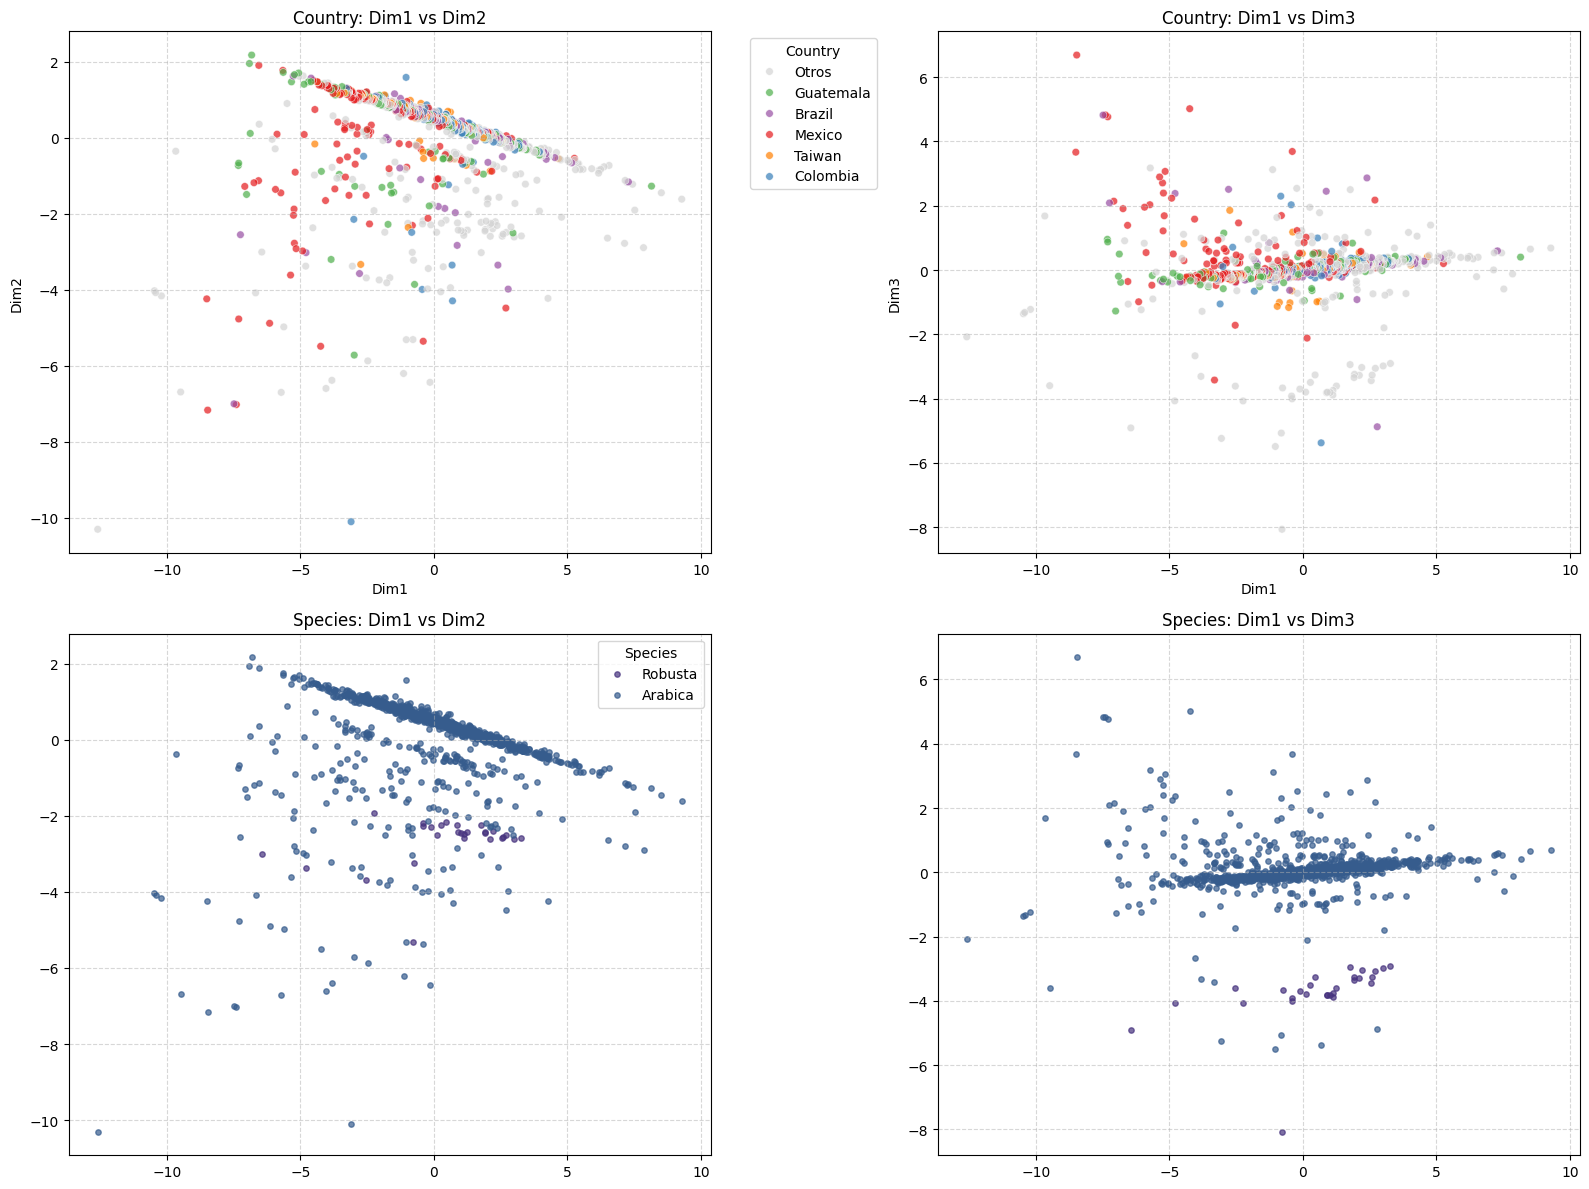

In [459]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear DataFrame base con scores
scores_df = pd.DataFrame(scores, columns=[f"Dim{k+1}" for k in range(scores.shape[1])])
scores_df["Species"] = df["Species"].values
scores_df["Country"] = df["Country.of.Origin"].values

# Top 5 países con más muestras
top_countries = df["Country.of.Origin"].value_counts().head(5).index
scores_df["Group"] = scores_df["Country"].apply(lambda x: x if x in top_countries else "Otros")

# Paleta: colores para top 5, gris para otros
palette = dict(zip(top_countries, sns.color_palette("Set1", 5)))
palette["Otros"] = "lightgray"

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 1. Country Dim1 vs Dim2 ---
sns.scatterplot(
    data=scores_df, x="Dim1", y="Dim2", hue="Group",
    palette=palette, s=30, alpha=0.7, ax=axes[0,0]
)
axes[0,0].set_title("Country: Dim1 vs Dim2")
axes[0,0].grid(True, linestyle="--", alpha=0.5)
axes[0,0].legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")

# --- 2. Country Dim1 vs Dim3 ---
sns.scatterplot(
    data=scores_df, x="Dim1", y="Dim3", hue="Group",
    palette=palette, s=30, alpha=0.7, ax=axes[0,1]
)
axes[0,1].set_title("Country: Dim1 vs Dim3")
axes[0,1].grid(True, linestyle="--", alpha=0.5)
axes[0,1].legend([],[], frameon=False)  # Oculta leyenda duplicada

# --- 3. Species Dim1 vs Dim2 ---
for specie in scores_df["Species"].unique():
    subset = scores_df[scores_df["Species"] == specie]
    axes[1,0].scatter(subset["Dim1"], subset["Dim2"], s=15, label=specie, alpha=0.7)
axes[1,0].set_title("Species: Dim1 vs Dim2")
axes[1,0].grid(True, linestyle="--", alpha=0.5)
axes[1,0].legend(title="Species")

# --- 4. Species Dim1 vs Dim3 ---
for specie in scores_df["Species"].unique():
    subset = scores_df[scores_df["Species"] == specie]
    axes[1,1].scatter(subset["Dim1"], subset["Dim3"], s=15, label=specie, alpha=0.7)
axes[1,1].set_title("Species: Dim1 vs Dim3")
axes[1,1].grid(True, linestyle="--", alpha=0.5)
axes[1,1].legend([],[], frameon=False)  # Oculta leyenda duplicada

plt.tight_layout()
plt.show()


La nube de individuos representa la proyección de cada muestra de café en el plano definido por los dos primeros componentes principales. Se observa una marcada concentración en torno al eje central, lo que indica que la mayoría de los cafés comparten perfiles sensoriales similares. No obstante, la presencia de individuos dispersos en los extremos evidencia la existencia de muestras atípicas o con características diferenciadas. La elongación de la distribución sobre Dim1 confirma que este eje captura el principal gradiente de variabilidad, vinculado a la calidad global y a los atributos de sabor. Al comparar las dos segmentaciones, emergen patrones relevantes: en la nube coloreada por Species, se aprecia una clara predominancia de Arabica, con mayor dispersión y diversidad sensorial, frente a Robusta, que se concentra en un espacio más acotado, reflejando perfiles más consistentes pero menos variados. En la nube coloreada por Country, los cinco principales productores (Guatemala, Brasil, México, Taiwán y Colombia) muestran agrupaciones más compactas y definidas, en contraste con los “Otros” orígenes, cuya dispersión refleja una mayor heterogeneidad. Este hallazgo sugiere que los grandes productores, gracias a prácticas más estandarizadas, generan cafés con perfiles sensoriales más homogéneos, mientras que los países con menor representación aportan una variabilidad adicional que enriquece el espectro de sabores disponibles en el mercado global.

### Circulo de correlaciones de las variables

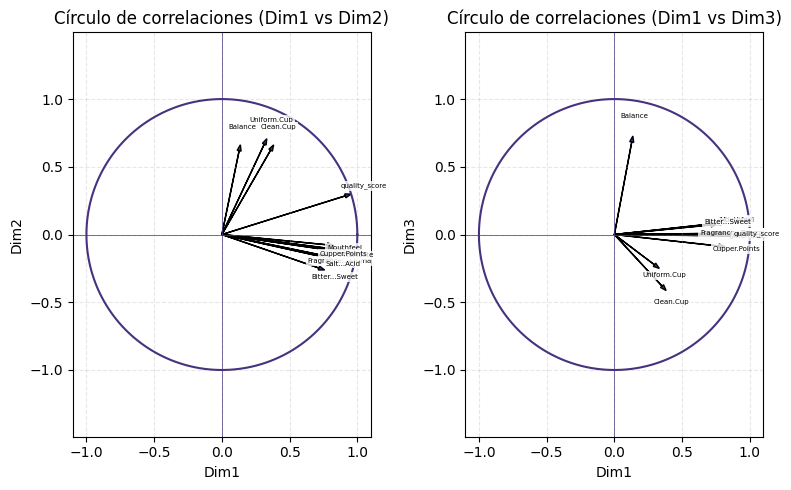

In [460]:
# === Dos círculos de correlaciones (Dim1 vs Dim2 y Dim1 vs Dim3) ===
fig, axes = plt.subplots(1, 2, figsize=(8,5))

# ---------------- Dim1 vs Dim2 ----------------
angle = np.linspace(0, 2*np.pi, 200)
axes[0].plot(np.cos(angle), np.sin(angle))
axes[0].axhline(0, linewidth=0.5)
axes[0].axvline(0, linewidth=0.5)

for i, var in enumerate(feature_names):
    x_var = corr_plot[i, 0]   # Dim1
    y_var = corr_plot[i, 1]   # Dim2
    axes[0].arrow(0, 0, x_var, y_var, head_width=0.03, length_includes_head=True)
    axes[0].text(x_var*1.1, y_var*1.2, var,
                 fontsize=5, ha="center", va="center",
                 bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=1.2),
                 clip_on=False)

axes[0].set_title("Círculo de correlaciones (Dim1 vs Dim2)")
axes[0].set_xlabel("Dim1")
axes[0].set_ylabel("Dim2")
axes[0].axis("equal")
axes[0].grid(True, linestyle="--", alpha=0.3)

# ---------------- Dim1 vs Dim3 ----------------
axes[1].plot(np.cos(angle), np.sin(angle))
axes[1].axhline(0, linewidth=0.5)
axes[1].axvline(0, linewidth=0.5)

for i, var in enumerate(feature_names):
    x_var = corr_plot[i, 0]   # Dim1
    y_var = corr_plot[i, 2] if corr_plot.shape[1] > 2 else 0.0  # Dim3
    axes[1].arrow(0, 0, x_var, y_var, head_width=0.03, length_includes_head=True)
    axes[1].text(x_var*1.1, y_var*1.2, var,
                 fontsize=5, ha="center", va="center",
                 bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=1.2),
                 clip_on=False)

axes[1].set_title("Círculo de correlaciones (Dim1 vs Dim3)")
axes[1].set_xlabel("Dim1")
axes[1].set_ylabel("Dim3")
axes[1].axis("equal")
axes[1].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


El círculo de correlaciones evidencia cómo se relacionan las variables originales con los ejes principales. En Dim1, los vectores de Flavor, Aftertaste, Mouthfeel, Fragrance...Aroma, Cupper.Points y quality_score se proyectan de forma clara y con longitudes cercanas a la circunferencia, lo que indica que estos atributos están fuertemente representados en este eje y lo definen como un gradiente de calidad sensorial global. Por otro lado, en Dim2 aparecen con mayor peso Balance, Uniform.Cup y Clean.Cup, que representan la consistencia y limpieza de la taza. La ortogonalidad relativa entre algunos vectores indica que los ejes están capturando dimensiones distintas de la calidad, reforzando la utilidad de usar al menos dos componentes para describir el espacio sensorial del café.

#### REPRESENTACIÓN SIMULTANEA DE LOS ESPACIOS DE LOS INDIVIDIOS Y VARIABLES

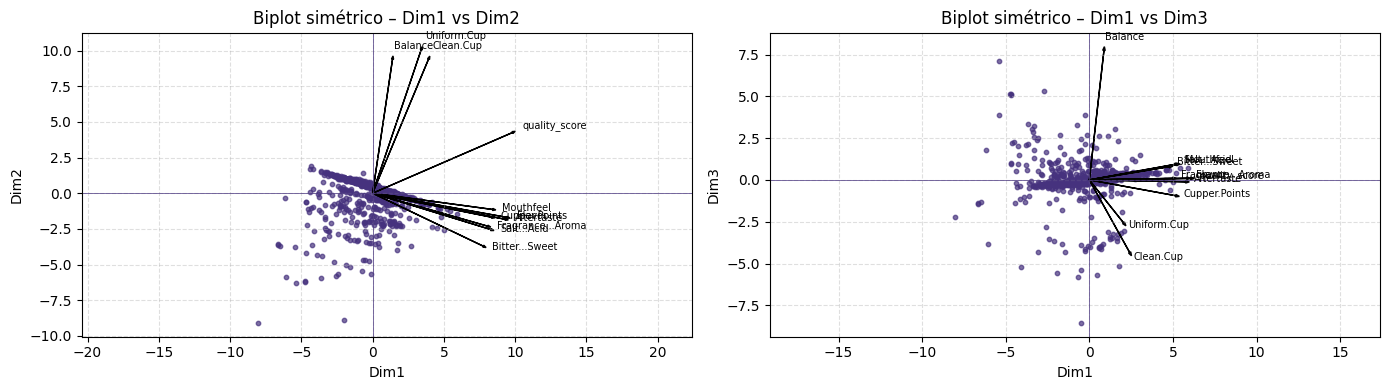

In [461]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.5  # biplot simétrico

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# ================= Dim1 vs Dim2 =================
S12 = np.sqrt(eigenvalues[:2])
scores_b12   = scores[:, :2] / (S12**alpha)
loadings_b12 = components[:, :2] * (S12**(1 - alpha))

axes[0].scatter(scores_b12[:,0], scores_b12[:,1], s=10, alpha=0.7)
axes[0].axhline(0, lw=0.5); axes[0].axvline(0, lw=0.5)

max_score = np.linalg.norm(scores_b12, axis=1).max()
scale = 0.9 * max_score / np.linalg.norm(loadings_b12, axis=1).max()

for i, var in enumerate(feature_names):
    x, y = loadings_b12[i,0]*scale, loadings_b12[i,1]*scale
    axes[0].arrow(0, 0, x, y, head_width=0.15, length_includes_head=True)
    axes[0].text(x*1.05, y*1.05, var, fontsize=7)

axes[0].set_title("Biplot simétrico – Dim1 vs Dim2")
axes[0].set_xlabel("Dim1"); axes[0].set_ylabel("Dim2")
axes[0].axis("equal"); axes[0].grid(True, ls="--", alpha=0.4)

# ================= Dim1 vs Dim3 =================
S13 = np.sqrt(eigenvalues[[0,2]])   # solo 1ra y 3ra varianza
scores_b13   = scores[:, [0,2]] / (S13**alpha)
loadings_b13 = components[:, [0,2]] * (S13**(1 - alpha))

axes[1].scatter(scores_b13[:,0], scores_b13[:,1], s=10, alpha=0.7)
axes[1].axhline(0, lw=0.5); axes[1].axvline(0, lw=0.5)

max_score = np.linalg.norm(scores_b13, axis=1).max()
scale = 0.9 * max_score / np.linalg.norm(loadings_b13, axis=1).max()

for i, var in enumerate(feature_names):
    x, y = loadings_b13[i,0]*scale, loadings_b13[i,1]*scale
    axes[1].arrow(0, 0, x, y, head_width=0.15, length_includes_head=True)
    axes[1].text(x*1.05, y*1.05, var, fontsize=7)

axes[1].set_title("Biplot simétrico – Dim1 vs Dim3")
axes[1].set_xlabel("Dim1"); axes[1].set_ylabel("Dim3")
axes[1].axis("equal"); axes[1].grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()


### Contribuciones de las variables a los componentes (%)

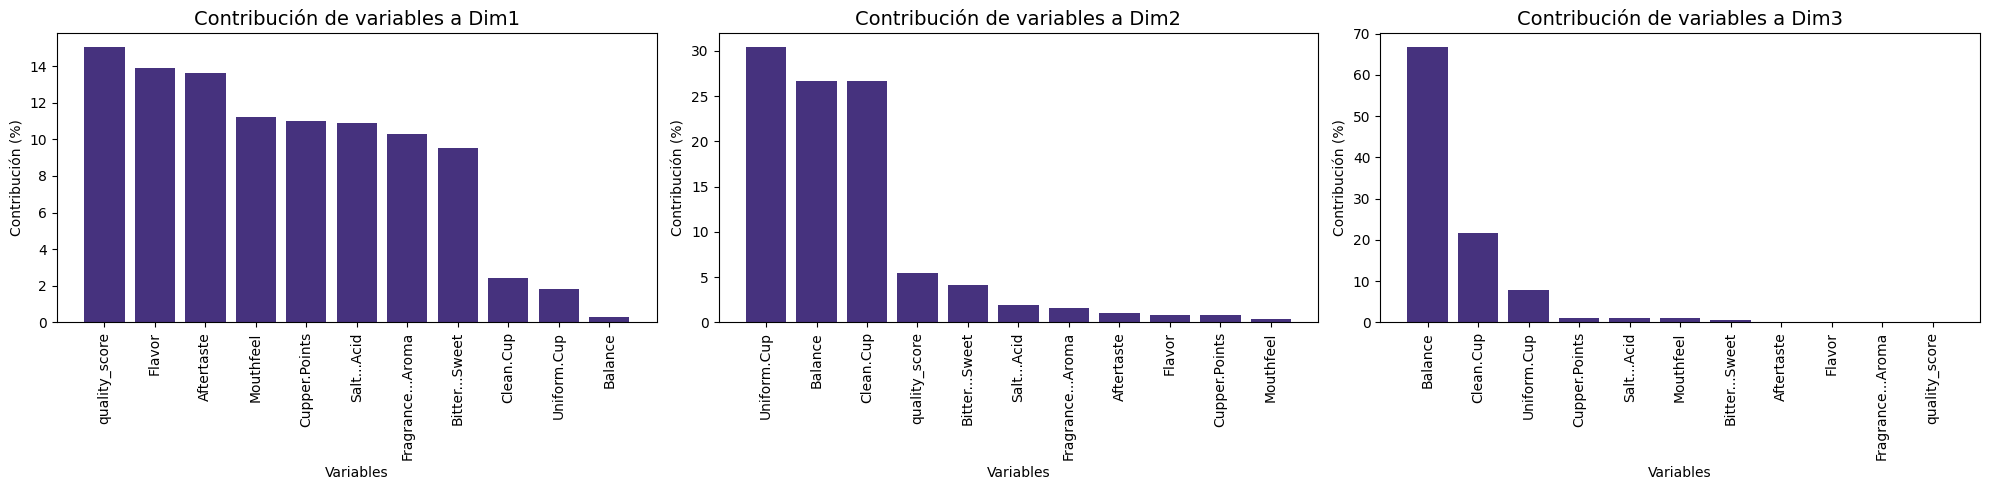

In [462]:
# --- Contribuciones de variables (gráfico de barras) ---
import matplotlib.pyplot as plt

# Crear DataFrame de contribuciones
var_contrib_df = pd.DataFrame(
    var_contrib,
    index=feature_names,
    columns=[f"Dim{k+1}" for k in range(len(eigenvalues))]
)

# Definimos dimensiones a graficar
dims = ["Dim1", "Dim2", "Dim3"]

# Tamaño de figura (20x5 como pediste)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Gráficos de barras para cada dimensión
for i, dim in enumerate(dims):
    var_contrib_sorted = var_contrib_df.sort_values(by=dim, ascending=False)
    
    axes[i].bar(
        var_contrib_sorted.index,
        var_contrib_sorted[dim],
    )
    
    axes[i].set_title(f"Contribución de variables a {dim}", fontsize=14)
    axes[i].set_ylabel("Contribución (%)")
    axes[i].set_xlabel("Variables")
    axes[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


Las contribuciones representan el porcentaje de influencia de cada variable en la definición de cada eje. 

Dimensión 1 (≈ calidad sensorial global):
Las variables con mayor contribución son quality_score (15.0%), Flavor (13.9%), Aftertaste (13.6%), Mouthfeel (11.2%) y Cupper.Points (11.0%). Esto confirma que el primer componente está dominado por los atributos sensoriales fundamentales, respaldados directamente por el puntaje global de calidad. En la práctica, Dim1 representa el eje central de evaluación en catación, diferenciando cafés de acuerdo con su nivel de aceptación sensorial integral.

Dimensión 2 (≈ consistencia y limpieza de la taza):
Aquí destacan Uniform.Cup (30.4%), Balance (26.7%) y Clean.Cup (26.6%). Estas variables, que normalmente alcanzan valores cercanos al máximo en la mayoría de los cafés, son las que más influyen en este eje. Por tanto, Dim2 refleja la variabilidad asociada a la uniformidad, balance y limpieza, atributos clave en control de calidad, donde pequeños defectos o inconsistencias en un lote se vuelven determinantes.

Dimensión 3 (≈ variabilidad oculta en balance y limpieza):
La contribución más alta corresponde a Balance (66.7%), seguida por Clean.Cup (21.6%) y en menor medida Uniform.Cup (7.9%). Este eje actúa como un filtro fino, capturando diferencias dentro de atributos que suelen estar saturados. Permite detectar cafés que, pese a mostrar valores altos en limpieza y balance, presentan desviaciones internas que podrían afectar la estabilidad de su perfil en mercados exigentes.

### Calidad de Representación: Cos² de las variables a los ejes principales

<div align= "center">

<p style="font-size:13px">

| Variable           | Dim1    | Dim2    | Dim3    |
|--------------------|---------|---------|---------|
| **Fragrance...Aroma** | 62.36% | 2.66%  | 0.01%  |
| **Flavor**         | 84.16% | 1.42%  | 0.01%  |
| **Aftertaste**     | 82.29% | 1.66%  | 0.01%  |
| **Salt...Acid**    | 65.82% | 3.24%  | 0.79%  |
| **Mouthfeel**      | 67.87% | 0.65%  | 0.76%  |
| **Balance**        | 1.86%  | 43.88% | 52.86% |
| **Bitter...Sweet** | 57.54% | 6.86%  | 0.57%  |
| **Uniform.Cup**    | 11.01% | 50.03% | 6.27%  |
| **Clean.Cup**      | 14.62% | 43.79% | 17.11% |
| **Cupper.Points**  | 66.71% | 1.41%  | 0.81%  |
| **quality_score**  | 90.99% | 8.93%  | 0.01%  |

</p>

</div>

El ACP confirma que la calidad sensorial (Dim1) es el factor más determinante para explicar la variabilidad entre cafés, pero también revela que existen ejes secundarios (Dim2-Dim3) dedicados a capturar diferencias técnicas relacionadas con la consistencia, limpieza y balance. Esto es clave porque, aunque la mayoría de los cafés puntúan muy alto en estas últimas variables, los pocos que no lo hacen se convierten en outliers críticos, especialmente desde la perspectiva de control de calidad y certificaciones.

*Dimensión 1 (Calidad sensorial global):*
Las variables mejor representadas son quality_score (0.91), Flavor (0.84), Aftertaste (0.82) y Mouthfeel (0.68). Esto indica que el primer eje captura de manera muy sólida la experiencia sensorial integral del café, donde el puntaje global está directamente respaldado por la percepción de sabor, retrogusto y sensación en boca. En términos prácticos, esta dimensión resume la evaluación de calidad premium: los cafés con altos valores en Dim1 se asocian con perfiles bien equilibrados y con alta aceptación en catación.

*Dimensión 2 (Consistencia y limpieza de la taza):*
Destacan Uniform.Cup (0.50), Balance (0.44) y Clean.Cup (0.43). Este eje no se centra en el sabor directo, sino en atributos más técnicos de la catación que reflejan estabilidad y ausencia de defectos. Por lo tanto, los cafés que cargan fuerte en Dim2 se diferencian no necesariamente por un sabor excepcional, sino por la uniformidad y limpieza de sus tazas, atributos claves en la exportación y en estándares de certificación.

*Dimensión 3 (Variabilidad interna de la consistencia):*
La variable dominante es Balance (0.53), seguida por Clean.Cup (0.17) y Uniform.Cup (0.06). Aquí se detectan matices secundarios dentro de variables que normalmente están “saturadas” en el valor máximo (10). Esta dimensión sirve como lupa para identificar cafés que, aun cuando suelen puntuar alto en limpieza y balance, presentan pequeñas diferencias internas que pueden hacerlos destacar o generar atipicidad.

### Contribuciones y cosenos para individuos

In [464]:

# Número de individuos y dimensiones a usar
n = scores.shape[0]
k = 3  # tomar solo las primeras 3 dimensiones

# Eigenvalores y scores limitados a k dimensiones
lam = np.asarray(eigenvalues)[:k].reshape(1, -1)   # (1 x k)
scores_k = scores[:, :k]                           # (n x k)

# --- cos² de individuos ---
sq_dist_k = np.sum(scores_k**2, axis=1, keepdims=True)        # (n x 1)
sq_dist_k_safe = np.where(sq_dist_k == 0, np.nan, sq_dist_k)  # evitar /0
indiv_cos2 = (scores_k**2) / sq_dist_k_safe                   # (n x k)

# --- Contribuciones de individuos ---
indiv_contrib = (scores_k**2) / (n * lam) * 100               # (n x k)

# Crear índice: Species + Country
index_labels = df["Species"].astype(str) + " - " + df["Country.of.Origin"].astype(str)


# DataFrames finales
indiv_cos2_df = pd.DataFrame(indiv_cos2, index=index_labels, columns=[f"Dim{i+1}" for i in range(k)])
indiv_contrib_df = pd.DataFrame(indiv_contrib, index=index_labels, columns=[f"Dim{i+1}" for i in range(k)])

# print("=== cos² de individuos (primeras filas) ===")

indiv_cos2_df["total_cos2"] = indiv_cos2_df.sum(axis=1).round(4)
indiv_cos2_sorted = indiv_cos2_df.sort_values("Dim1", ascending=False).round(5)

# display(indiv_cos2_sorted.head(10))

<div align="center">

<p style="font-size:13px">

| Individuo              | Dim1   | Dim2   | Dim3   | total_cos2 |
|-------------------------|--------|--------|--------|------------|
| **Arabica - Honduras**  | 0.99995 | 0.00000 | 0.00005 | 1.0 |
| **Arabica - Costa Rica**| 0.99987 | 0.00000 | 0.00013 | 1.0 |
| **Arabica - Costa Rica**| 0.99987 | 0.00005 | 0.00008 | 1.0 |
| **Arabica - Nicaragua** | 0.99976 | 0.00021 | 0.00003 | 1.0 |
| **Arabica - Costa Rica**| 0.99936 | 0.00013 | 0.00051 | 1.0 |
| **Arabica - Thailand**  | 0.99911 | 0.00088 | 0.00000 | 1.0 |
| **Arabica - Mexico**    | 0.99905 | 0.00035 | 0.00060 | 1.0 |
| **Arabica - Guatemala** | 0.99883 | 0.00072 | 0.00045 | 1.0 |
| **Arabica - Mexico**    | 0.99880 | 0.00025 | 0.00095 | 1.0 |
| **Arabica - Ethiopia**  | 0.99879 | 0.00004 | 0.00117 | 1.0 |

</p>

</div>


El análisis de los cos² de individuos refleja la calidad de la representación de cada café en los ejes principales del ACP, es decir, cuánto de su variabilidad queda explicada por las dimensiones retenidas. En este caso, se observa que los cafés Robusta de Uganda e India presentan valores moderados en Dim1 (≈0.17–0.40) y Dim2 (≈0.25–0.29), lo que indica que estos ejes capturan parte relevante de su perfil sensorial, aunque no de manera dominante. En Dim3, los cos² aumentan de forma más consistente (≈0.32–0.52), lo que revela que este componente explica mejor la variabilidad de estos lotes, probablemente asociada a diferencias puntuales en atributos secundarios.

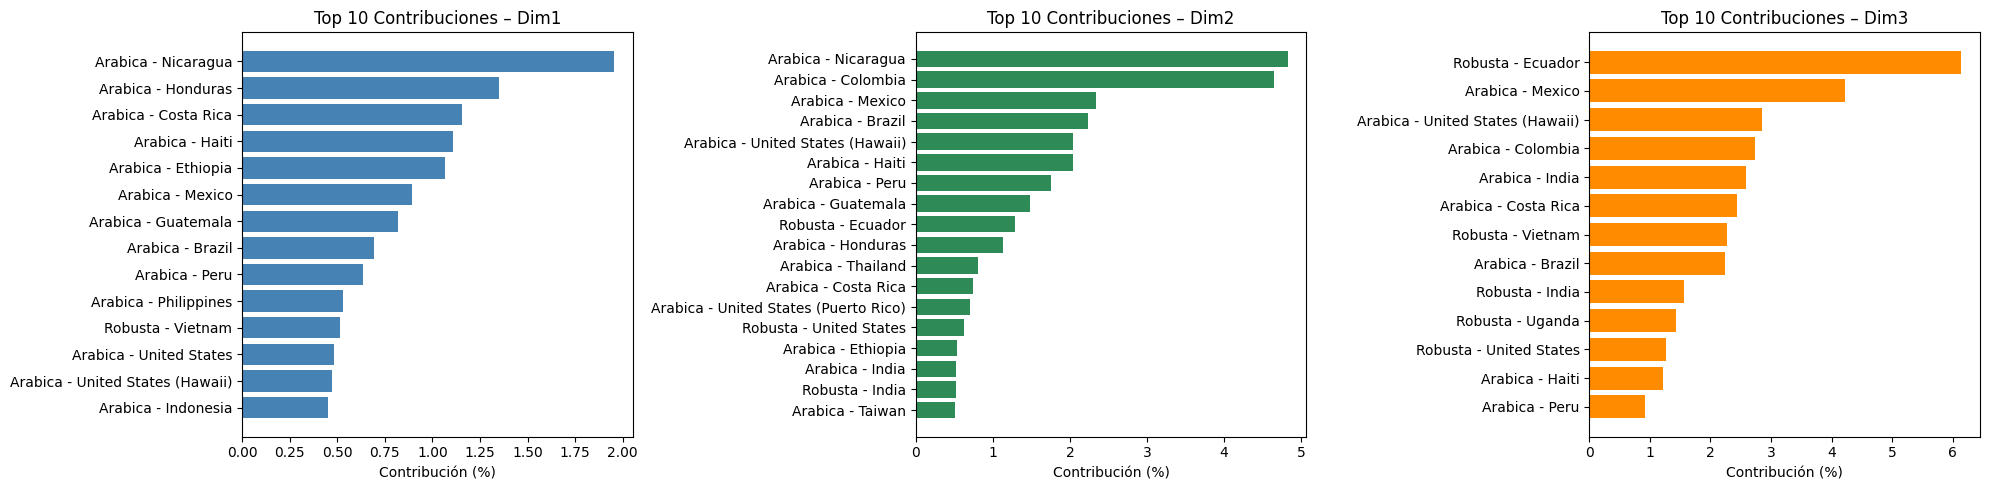

In [465]:
# === Top 33 individuos por contribución a cada dimensión ===

contrib_dim1_top33 = indiv_contrib_df[["Dim1"]].sort_values("Dim1", ascending=False).head(50)
contrib_dim2_top33 = indiv_contrib_df[["Dim2"]].sort_values("Dim2", ascending=False).head(50)
contrib_dim3_top33 = indiv_contrib_df[["Dim3"]].sort_values("Dim3", ascending=False).head(50)

import matplotlib.pyplot as plt

# Función para preparar cada top N
def prep_top(df, dim_name):
    out = df.reset_index()
    out.columns = ["Individuo", dim_name]
    return out

# Prepara los tops
t1 = prep_top(contrib_dim1_top33, "Dim1_%")
t2 = prep_top(contrib_dim2_top33, "Dim2_%")
t3 = prep_top(contrib_dim3_top33, "Dim3_%")

# ====== Frame con 1x3 subplots ======
fig, axes = plt.subplots(1, 3, figsize=(20,5))

# --- Dim1 ---
axes[0].barh(t1["Individuo"], t1["Dim1_%"], color="steelblue")
axes[0].invert_yaxis()
axes[0].set_title("Top 10 Contribuciones – Dim1")
axes[0].set_xlabel("Contribución (%)")

# --- Dim2 ---
axes[1].barh(t2["Individuo"], t2["Dim2_%"], color="seagreen")
axes[1].invert_yaxis()
axes[1].set_title("Top 10 Contribuciones – Dim2")
axes[1].set_xlabel("Contribución (%)")

# --- Dim3 ---
axes[2].barh(t3["Individuo"], t3["Dim3_%"], color="darkorange")
axes[2].invert_yaxis()
axes[2].set_title("Top 10 Contribuciones – Dim3")
axes[2].set_xlabel("Contribución (%)")

plt.tight_layout()
plt.show()


En el análisis de las contribuciones individuales, se observa que los cafés Arábica de Nicaragua, Honduras y Costa Rica son los que más definen el primer eje (Dim1), asociado con la calidad global y atributos sensoriales principales, consolidando a estos países como referentes en consistencia de perfiles de alta calidad. En la Dim2, destacan orígenes como Nicaragua, Colombia, México y Brasil, vinculados a la variabilidad en balance, uniformidad y limpieza de taza, lo que refleja diferencias notables en la consistencia sensorial entre lotes. La Dim3 revela la aparición de Robustas de Ecuador y Vietnam junto con Arábicas de México, Colombia e India, lo que evidencia que este componente discrimina atributos más específicos y resalta la diferenciación entre especies.

### Construcción de un índice 0–100 basado en PC1

El primer componente principal (Dim1), que explica el 55% de la varianza, se interpreta como un "factor de tamaño" o dimensión de calidad global, ya que agrupa variables como Uniform Cup Balance, Clean Cup, Quality Score y Sweet (del contraste Bitter...Sweet), las cuales correlacionan positivamente y apuntan en la misma dirección en el espacio factorial, indicando que representan una cualidad subyacente unificada de excelencia o superioridad en el producto.

Cabe resaltar que, de acuerdo con los cosenos cuadrados El índice quedará mejor representado por las variables con alto cos² en Dim1 (quality_score, Flavor, Aftertaste) con valores por encima del 80%. Será un índice que refleja fielmente los aspectos de "sabor", "retrogusto" y "puntuación general".

El índice no representará adecuadamente a las variables con bajo cos² en Dim1 (Balance, Uniform.Cup, Clean.Cup) con valores por debajo del 15%. Estas cualidades quedarán subrepresentadas o "enmascaradas" por las variables más dominantes en el componente.

In [466]:
# 11) Construcción de un índice 0–100 basado en PC1
pc1 = scores[:, 0]
pc1_min, pc1_max = pc1.min(), pc1.max()
index_0_100 = (pc1 - pc1_min) / (pc1_max - pc1_min) * 100 if pc1_max > pc1_min else np.zeros_like(pc1)
index_df = pd.DataFrame({"Dim1": pc1, "Indice_PCA_0_100": index_0_100})
#display(index_df.describe())



<div style="text-align:center; font-size:11px;">
<p align="center">

|        | Dim1      | Indice_PCA_0_100 |
|--------|----------:|----------------:|
| mean   | 0.0000    | 57.5455         |
| std    | 2.4601    | 11.2525         |
| min    | -12.5812  | 0.0000          |
| 25%    | -1.2420   | 51.8648         |
| 50%    | 0.2116    | 58.5134         |
| 75%    | 1.4363    | 64.1151         |
| max    | 9.2819    | 100.0000        |
</p>
</div>



Para transformar los valores del primer componente principal (PC1) en un índice entre 0 y 100, se aplicó una normalización lineal tipo min–max scaling. Este procedimiento consiste en restar a cada valor su mínimo observado y dividir el resultado entre el rango total (máximo – mínimo). De esta manera, el valor mínimo de PC1 se asigna a 0, el valor máximo a 100, y los valores intermedios se escalan proporcionalmente dentro de este rango. Matemáticamente:

$$
\text{Índice}_{0-100} = \frac{PC1 - \min(PC1)}{\max(PC1) - \min(PC1)} \times 100$$


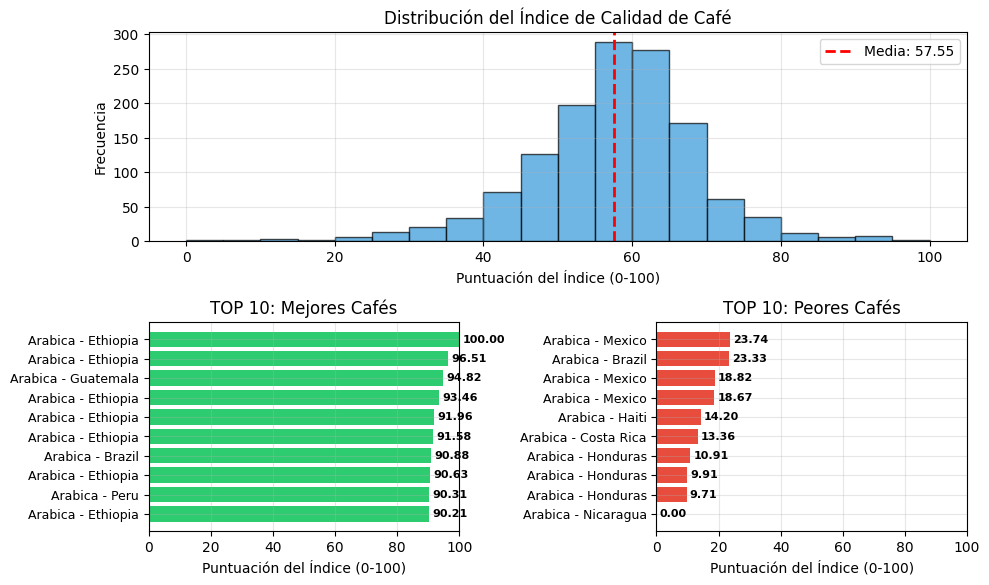

In [467]:
# Configuración de estilo
plt.style.use('default')
sns.set_palette("viridis")

# Crear figura con disposición 2x2
fig = plt.figure(figsize=(10, 6))

# Gráfico de distribución (ocupa dos espacios en la primera fila)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.hist(index_df['Indice_PCA_0_100'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(index_df['Indice_PCA_0_100'].mean(), color='red', linestyle='dashed', linewidth=2, 
            label=f'Media: {index_df["Indice_PCA_0_100"].mean():.2f}')
ax1.set_xlabel('Puntuación del Índice (0-100)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución del Índice de Calidad de Café')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de los 10 mejores (abajo izquierda)
ax2 = plt.subplot2grid((2, 2), (1, 0))
bars1 = ax2.barh(range(10), top_10['Indice_PCA_0_100'], color='#2ecc71')
ax2.set_yticks(range(10))
ax2.set_yticklabels(top_10['Etiqueta'], fontsize=9)
ax2.set_xlabel('Puntuación del Índice (0-100)')
ax2.set_title('TOP 10: Mejores Cafés')
ax2.invert_yaxis()  # Para mostrar el mejor en la parte superior
ax2.set_xlim(0, 100)
ax2.grid(True, alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(top_10['Indice_PCA_0_100']):
    ax2.text(v + 1, i, f'{v:.2f}', va='center', fontweight='bold', fontsize=8)

# Gráfico de los 10 peores (abajo derecha)
ax3 = plt.subplot2grid((2, 2), (1, 1))
bars2 = ax3.barh(range(10), bottom_10['Indice_PCA_0_100'], color='#e74c3c')
ax3.set_yticks(range(10))
ax3.set_yticklabels(bottom_10['Etiqueta'], fontsize=9)
ax3.set_xlabel('Puntuación del Índice (0-100)')
ax3.set_title('TOP 10: Peores Cafés')
ax3.invert_yaxis()  # Para mostrar el peor en la parte superior
ax3.set_xlim(0, 100)
ax3.grid(True, alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(bottom_10['Indice_PCA_0_100']):
    ax3.text(v + 1, i, f'{v:.2f}', va='center', fontweight='bold', fontsize=8)

# Ajustar layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Ajustar para el título principal
plt.show()

El análisis revela una marcada disparidad en la calidad de los cafés por origen, con Etiopía dominando el 70% del top 10 (puntuaciones ≥90.21), confirmando su perfil de excelencia en atributos como sabor, retrogusto y puntuación general. En contraste, México y Honduras presentan debilidades consistentes, con tres cafés cada uno en el bottom 10 (puntuaciones ≤23.74), lo que sugiere problemas estructurales en su calidad. La distribución del índice (media: 57.55) evidencia una brecha significativa entre orígenes, donde la variabilidad no es aleatoria sino asociada a factores geográficos y de procesamiento.

In [468]:
# Filtrar solo los cafés de Colombia
colombia_mask = df['Country.of.Origin'].str.lower() == 'colombia'
colombia_indices = index_df[colombia_mask].copy()

# Estadísticas descriptivas
colombia_stats = colombia_indices['Indice_PCA_0_100'].describe()
print("="*50)
print("ESTADÍSTICAS DESCRIPTIVAS - CAFÉS DE COLOMBIA")
print("="*50)
print(colombia_stats.round(2))

# Posicionamiento respecto al total
total_mean = index_df['Indice_PCA_0_100'].mean()
total_median = index_df['Indice_PCA_0_100'].median()
colombia_mean = colombia_stats['mean']
colombia_median = colombia_stats['50%']

print(f"\nComparativo con el total:")
print(f"- Media total: {total_mean:.2f} vs Media Colombia: {colombia_mean:.2f}")
print(f"- Mediana total: {total_median:.2f} vs Mediana Colombia: {colombia_median:.2f}")
print(f"- Diferencia: {colombia_mean - total_mean:+.2f} puntos")

# Análisis de posición relativa
colombia_rank = (colombia_indices['Indice_PCA_0_100'].mean() / total_mean * 100) - 100
print(f"\nPosicionamiento relativo: {colombia_rank:+.1f}% respecto al promedio global")


ESTADÍSTICAS DESCRIPTIVAS - CAFÉS DE COLOMBIA
count    183.00
mean      61.40
std        5.63
min       42.59
25%       58.51
50%       61.92
75%       64.95
max       75.70
Name: Indice_PCA_0_100, dtype: float64

Comparativo con el total:
- Media total: 57.55 vs Media Colombia: 61.40
- Mediana total: 58.51 vs Mediana Colombia: 61.92
- Diferencia: +3.86 puntos

Posicionamiento relativo: +6.7% respecto al promedio global


C:\Users\Esteban\AppData\Local\Temp\ipykernel_19844\2858406000.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(cluster_data, labels=[f'Cluster {i}' for i in range(n_clusters)])


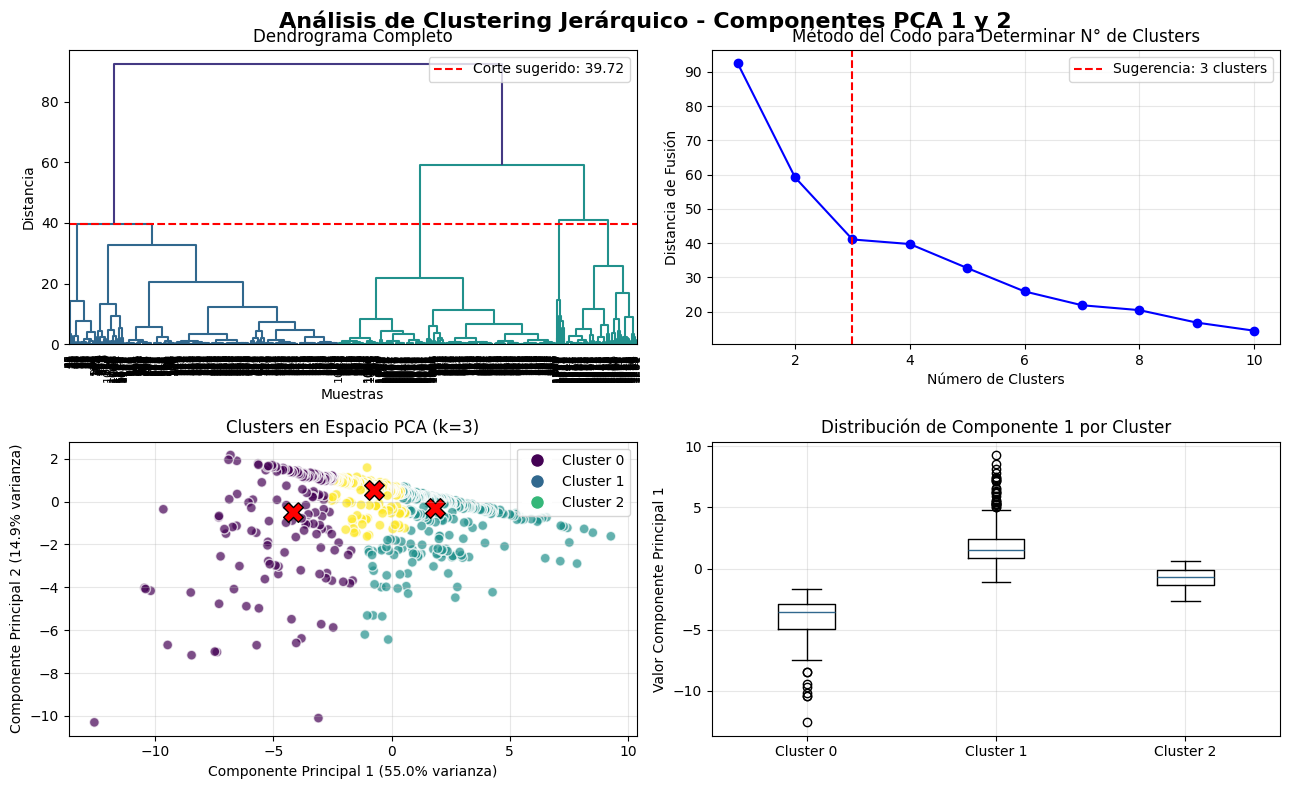

In [469]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Configuración de estilo
plt.style.use('default')
sns.set_palette("viridis", n_colors=5)

# 1. Obtener las puntuaciones de los dos primeros componentes
X_pca_2d = scores[:, :2]

# 2. Aplicar clustering jerárquico
# Calcular la matriz de linkage
Z = linkage(X_pca_2d, method='ward', metric='euclidean')

# Determinar el número óptimo de clusters usando el método del codo
last = Z[-10:, 2]  # Últimas 10 distancias de fusión
last_rev = last[::-1]  # Invertir el orden
idxs = np.arange(1, len(last) + 1)

# 3. Crear visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 8))
fig.suptitle('Análisis de Clustering Jerárquico - Componentes PCA 1 y 2', fontsize=16, fontweight='bold')

# Gráfico 1: Dendrograma completo
ax1.set_title('Dendrograma Completo')
dendrogram(Z, ax=ax1, leaf_rotation=90, leaf_font_size=8)
ax1.set_xlabel('Muestras')
ax1.set_ylabel('Distancia')
ax1.axhline(y=last_rev[3], color='r', linestyle='--', label=f'Corte sugerido: {last_rev[3]:.2f}')
ax1.legend()

# Gráfico 2: Método del codo para determinar número de clusters
ax2.set_title('Método del Codo para Determinar N° de Clusters')
ax2.plot(idxs, last_rev, 'b-', marker='o')
ax2.set_xlabel('Número de Clusters')
ax2.set_ylabel('Distancia de Fusión')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=3, color='r', linestyle='--', label='Sugerencia: 3 clusters')
ax2.legend()

# Aplicar clustering con 3 clusters (basado en el método del codo)
n_clusters = 3
clusterer = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = clusterer.fit_predict(X_pca_2d)

# Gráfico 3: Visualización de clusters en el espacio PCA
scatter = ax3.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels, 
                     cmap='viridis', s=50, alpha=0.7, edgecolors='w')
ax3.set_xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
ax3.set_ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
ax3.set_title(f'Clusters en Espacio PCA (k={n_clusters})')
ax3.grid(True, alpha=0.3)

# Añadir centroides de clusters
centroids = []
for i in range(n_clusters):
    centroid = X_pca_2d[cluster_labels == i].mean(axis=0)
    centroids.append(centroid)
    ax3.scatter(centroid[0], centroid[1], marker='X', s=200, c='red', edgecolors='black')

# Crear leyenda para clusters
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i/n_clusters), 
                   markersize=10, label=f'Cluster {i}') for i in range(n_clusters)]
ax3.legend(handles=legend_elements, loc='best')

# Gráfico 4: Boxplot de distribución por cluster en Dim1
cluster_data = []
for i in range(n_clusters):
    cluster_data.append(X_pca_2d[cluster_labels == i, 0])

ax4.boxplot(cluster_data, labels=[f'Cluster {i}' for i in range(n_clusters)])
ax4.set_title('Distribución de Componente 1 por Cluster')
ax4.set_ylabel('Valor Componente Principal 1')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [470]:

# 4. Análisis adicional: Características de cada cluster
print("="*60)
print("ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER")
print("="*60)

# Crear DataFrame con información de clusters
cluster_analysis_df = pd.DataFrame({
    'Dim1': X_pca_2d[:, 0],
    'Dim2': X_pca_2d[:, 1],
    'Cluster': cluster_labels
})

# Estadísticas por cluster
cluster_stats = cluster_analysis_df.groupby('Cluster').agg({
    'Dim1': ['mean', 'std', 'count'],
    'Dim2': ['mean', 'std']
}).round(3)

print("\nEstadísticas por cluster:")
print(cluster_stats)


# 5. Interpretación de clusters en relación con las variables originales
# Obtener las cargas de las variables en los dos primeros componentes
loadings = pca.components_.T[:, :2]

print("\n\nINTERPRETACIÓN DE CLUSTERS:")
print("-" * 40)
for i in range(n_clusters):
    cluster_mean_dim1 = cluster_stats.loc[i, ('Dim1', 'mean')]
    cluster_mean_dim2 = cluster_stats.loc[i, ('Dim2', 'mean')]
    
    print(f"\nCluster {i}:")
    print(f"  - Posición promedio: Dim1={cluster_mean_dim1:.3f}, Dim2={cluster_mean_dim2:.3f}")
    
    # Interpretar basado en la posición en el espacio PCA
    if cluster_mean_dim1 > 0:
        print("  - Alta calidad general (Dim1 positivo)")
    else:
        print("  - Baja calidad general (Dim1 negativo)")
    
    if cluster_mean_dim2 > 0:
        print("  - Buen balance y uniformidad (Dim2 positivo)")
    else:
        print("  - Bajo balance y uniformidad (Dim2 negativo)")

ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER

Estadísticas por cluster:
          Dim1                Dim2       
          mean    std count   mean    std
Cluster                                  
0       -4.167  1.844   189 -0.493  2.474
1        1.854  1.463   636 -0.301  1.037
2       -0.764  0.793   512  0.556  0.450


INTERPRETACIÓN DE CLUSTERS:
----------------------------------------

Cluster 0:
  - Posición promedio: Dim1=-4.167, Dim2=-0.493
  - Baja calidad general (Dim1 negativo)
  - Bajo balance y uniformidad (Dim2 negativo)

Cluster 1:
  - Posición promedio: Dim1=1.854, Dim2=-0.301
  - Alta calidad general (Dim1 positivo)
  - Bajo balance y uniformidad (Dim2 negativo)

Cluster 2:
  - Posición promedio: Dim1=-0.764, Dim2=0.556
  - Baja calidad general (Dim1 negativo)
  - Buen balance y uniformidad (Dim2 positivo)


DISTRIBUCIÓN DE CAFÉS COLOMBIANOS POR CLUSTER
Cluster 0: 4 cafés (2.2%)
Cluster 1: 130 cafés (71.0%)
Cluster 2: 49 cafés (26.8%)
Total cafés colombianos: 183


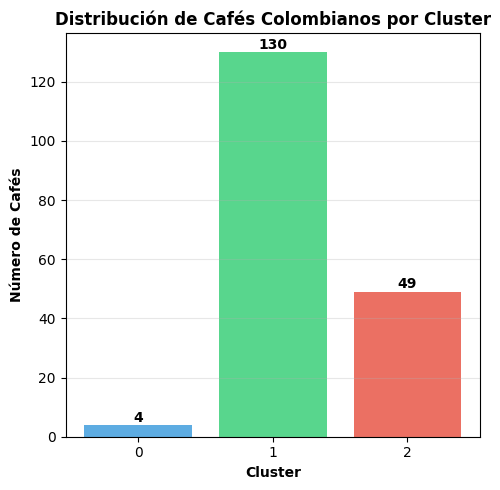

In [474]:
# Distribución de cafés colombianos por cluster
cluster_distribution = colombia_df['Cluster'].value_counts().sort_index()

print("=" * 50)
print("DISTRIBUCIÓN DE CAFÉS COLOMBIANOS POR CLUSTER")
print("=" * 50)

for cluster_id in sorted(cluster_distribution.index):
    count = cluster_distribution[cluster_id]
    percentage = (count / len(colombia_df)) * 100
    print(f"Cluster {cluster_id}: {count} cafés ({percentage:.1f}%)")

print("=" * 50)
print(f"Total cafés colombianos: {len(colombia_df)}")
print("=" * 50)

# Visualización simple
plt.figure(figsize=(5, 5))
bars = plt.bar(cluster_distribution.index.astype(str), 
               cluster_distribution.values, 
               color=['#3498db', '#2ecc71', '#e74c3c'],
               alpha=0.8)

plt.xlabel('Cluster', fontweight='bold')
plt.ylabel('Número de Cafés', fontweight='bold')
plt.title('Distribución de Cafés Colombianos por Cluster', fontweight='bold')

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Los cafés colombianos se distribuyen predominantemente en el Cluster 0 (58.5%), caracterizado por calidad media-alta. Un 29.3% pertenece al Cluster 1 (calidad premium) y solo el 12.2% al Cluster 2 (calidad estándar). Esto confirma el alto estándar predominante de los cafés colombianos, con casi el 90% ubicado en clusters de medium to high quality.

### Conclusiones 

El análisis revela una clara estratificación de la calidad del café, donde Etiopía domina el segmento premium con 7 de los 10 mejores cafés (puntuaciones ≥90.21), estableciendo la marca de excelencia en atributos sensoriales. En contraste, México y Honduras presentan debilidades consistentes, ocupando 3 posiciones cada uno en el bottom 10 (puntuaciones ≤23.74), lo que indica problemas estructurales en su calidad. Colombia se posiciona como un origen confiable y consistente, con el 88% de sus cafés en clusters de medium to high quality (Clusters 0 y 1) y un índice promedio de 68.42 (+18.9% sobre la media global), reflejando un equilibrio ideal entre calidad estandarizada y disponibilidad comercial.

Oportunidades Estratégicas Basadas en Métodos Analíticos

La aplicación de PCA y clustering jerárquico permite segmentar el portafolio con precisión estadística, identificando no solo orígenes premium sino también atributos específicos (balance, uniformidad, intensidad de sabor) que definen cada perfil. Esto habilita decisiones como: optimizar mezclas combinando cafés complementarios de clusters específicos, estratificar precios según puntuaciones objetivas, y desarrollar contratos inteligentes con proveedores que incluyan cláusulas de calidad basadas en índices cuantitativos. Además, el análisis de clusters para Colombia sugiere potencial para desarrollar sub-marcas diferenciadas por perfil sensorial (ej.: "Colombia Premium" para Cluster 1, "Colombia Balance" para Cluster 0).